# Simulation for augmented flow cytometry via matrix sensing

We simulate a problem where we would like to perform flow cytometry with 64 markers but actually measure abundances for 4x that number - 256 proteins.

Instead of measuring the actual proteins, we measure random linear combinations of the proteins, each weighted equally (how will titration work?). In this notebook, we demonstrate that we can reconstruct the original protein expression matrix from measurements of linear combinations of proteins. 

Here, we have `num_cells`, `num_markers`, `pack_ratio`(how "compressed" is our dataset) to simulated dataset. The `rank` determines the rank of the true protein expression matrix (typically unknown). 

In [2]:
import numpy as np
from scipy.optimize import minimize, nnls, LinearConstraint, lsq_linear
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.sparse as sparse

In [3]:
num_cells = 10000
num_markers = 3
pack_ratio = 0.25
rank = 5
num_genes = int(num_markers/pack_ratio)

In [4]:

U_real = np.random.randn(num_cells, rank)*2+10
V_real = np.random.randn(num_genes, rank)*3+15
M = U_real@V_real.T
print('Size of the true protein matrix M is', M.shape)

Size of the true protein matrix M is (10000, 12)


In [5]:
P = np.random.choice([0, 1], size=(num_genes, num_markers), p=[1./4, 3./4])

P = P/P.sum(axis=1).reshape(-1, 1)

In [6]:
P

array([[0.        , 0.5       , 0.5       ],
       [0.5       , 0.5       , 0.        ],
       [0.5       , 0.        , 0.5       ],
       [1.        , 0.        , 0.        ],
       [0.        , 0.        , 1.        ],
       [0.33333333, 0.33333333, 0.33333333],
       [0.        , 0.5       , 0.5       ],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [0.5       , 0.5       , 0.        ],
       [0.5       , 0.5       , 0.        ],
       [0.33333333, 0.33333333, 0.33333333]])

In [48]:
D = M@P
D_vec = D.reshape(-1)
print('Size of the measured protein matrix D (measuring the linear combinations) is', D.shape)

Size of the measured protein matrix D (measuring the linear combinations) is (10000, 3)


In [49]:
print(D.sum(), M.sum())

90911488.92257829 90911488.92257829


### Alternating least squares

We factorize $M$ into $M = LR$, and this ensures that our final matrix is of rank `rank`. In this initial experiment, we cheat a bit and give it the known rank. However, missing the true rank shouldn't affect the final output all that much.

1. Initialize the factorized matrices to random positive numbers. 
2. Solve for $L$. This part is very easy, since each row of $L$ only depends on a single cell measurement (one row in $D$). 
3. Solve for $R$. This part is actually very difficult to solve exactly (with my talents). For now, I put in a very hacky substitute for actually performing NNLS.

The alternative to ALS is to minimize the rank of the solution matrix while holding the error as a constraint. This problem is NP-hard, but minimizing the nuclear norm (convex envelope of the rank function) is convex - however, this approach is intractable even beyond a few hundred cells.

In [50]:
L_current = np.random.randn(num_cells,rank)+10
R_current = np.random.randn(rank,num_genes)+10

In [51]:
def solve_L(R_current):
    
    A = P.T@R_current.T
    return np.apply_along_axis(lambda row: nnls(A, row)[0], axis=1, arr=D)

In [52]:
P_pinv = np.linalg.pinv(P)

def solve_R(L_current):

    temp = np.linalg.pinv(L_current)@D@P_pinv
    temp[temp < 0] = np.random.random()
    return temp

In [53]:
%%time
# u_error = []
# v_error = []
D_vec = D.reshape(-1)
for i in range(15):
    if i % 2 == 0:
        print('Iter', i)
    L_current = solve_L(R_current)
    R_current = solve_R(L_current)
        

Iter 0
Iter 2
Iter 4
Iter 6
Iter 8
Iter 10
Iter 12
Iter 14
CPU times: user 2.54 s, sys: 230 ms, total: 2.77 s
Wall time: 1.93 s


In [54]:
M_fitted = L_current@R_current

### How well do we do?

Reconstruction is possible up to an affine transformation - we can achieve near-perfect reconstruction standardized, relative protein expression, but not the actual measured values. I'm not sure if there's a way to fix this post-hoc. Correlation between simulated and reconstructed is always above >0.97 in this 0 measurement noise setting.


In [55]:
corrs = []
inters = []
coefs = []
for col in range(M.shape[1]):
    a = M[:, col]
    b = M_fitted[:, col]
    s, inter, r, _, _ = stats.linregress(a,b)
    inters.append(inter)
    coefs.append(s)
    corrs.append(r)

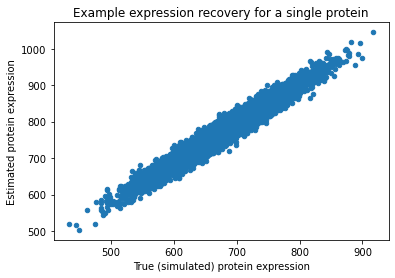

In [56]:
plt.scatter(a,b, s=20);
plt.title('Example expression recovery for a single protein')
plt.xlabel('True (simulated) protein expression'); plt.ylabel('Estimated protein expression');

Text(0.5, 1.0, 'Correlations between actual and reconstructed protein expression')

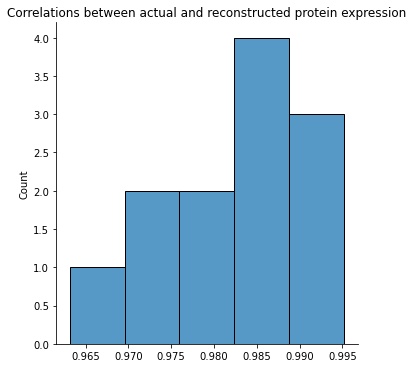

In [57]:
sns.displot(corrs)
plt.title('Correlations between actual and reconstructed protein expression')